## IBM Data Science Capstone Final Project: Battle of the Neighborhoods
## William Windsor

## Business Decision: Where to Locate a Professional Services Business -- San Francisco in the SoMa District (South of Market Street), or Seattle in the Pioneer Square district?

**+++++++++++++**
### Part 1(a): Project Description and Business Decision. This data science project proposes a decision structure to address the decision: where should I locate a professional services business, selecting between two neighborhoods that each have a concentration of high-tech startup companies? Example possibilities for the professional services business are:
-   Providing data science and data research services to tech companies (such as motivated by this IBM Data Science Professional Certification program)
-   Facilities planning and facilities location research services
-   Professional human resources contract services
-   Professional legal services; on-site health care and monitoring services
-   Security services such as IT software hosting and security, or personnel for on-site security monitoring

### This project focuses on two neighborhoods noted for their burgeoning growth of technology startups:
-   San Francisco, CA: South of Market Street region (SoMa)
-   Seattle, WA: Pioneer Square region

### Target Audience and Why They Would Care About This Problem:
<p>The target audience for this study is CEOs and entrepreneurs and venture capital companies looking to evaluate where to establish a new professional services business. They would care about this data analysis because the study will provide data sources and data science evaluation for several factors important for locating the business, with the thesis that professional services businesses generate greater success when they are located near their client field.</p>

### Part 1(b):  Decision Methodology, Description of the Data, and How It Will Be Used to Solve the Business Problem. For the decision of where to locate a professional services business servicing a high-tech startup hub, I focus on two major sets of factors: Financial Impact to the Company and Employee Quality of Life. Below I construct a location decision framework with the following methodology:
###  Assess Financial Impact to the Company, focusing on these three factors:
- Commercial Real Estate Prices for office real estate in each region, to rent/lease a facility for company operations
- Business Density Calculation for each region, to calculate and prioritize the neighborhood with the higher business density
- Corporate Tax Rates for each state and city

###  Assess Employee Quality of Life, focusing on these three factors:
- Proximity to Public Rail Transportation
- Number of restaurants in each neighborhood
- Number of exercise facilities in each neighborhood

###  Data Requirements: APIs and Datasets Utilized in this Analysis
- Foursquare Venues Database API
- Three Commercial Real Estate Databases: CityFeet.com, 42Floors.com, Loopnet.com
- State and City Corporate Income Tax References for California/San Francisco and Washington/Seattle
- API for San Francisco BART Rail Transit
- API for Seattle Link Rail Transit

### Part 2: Financial Impact to the Company. Financial impact of locating the business in each area, focusing on:
###   (a) Commercial Office Real Estate: property characteristics, locations, and rental/lease costs, based on current commercial office properties available at the time of this study. I constructed two commercial real estate listings datasets, one for each city and locale, structured with these fields for comparisons: 
-   Property Address
-   Neighborhood or Zip Code for the Specific Neighborhood
-   Rental Price per Month
-   Property Area in Square Feet
-   Rental Price per Square Foot

#### * Sources for Commercial Real Estate properties and availability in San Francisco and Seattle: https://www.cityfeet.com, https://42floors.com, https://www.loopnet.com

###   (b) Business Density Concentration for Each Neighborhood, Utilizing the Foursquare Dataset and DBSCAN Clustering (Density Based Spatial Clustering for Applications with Noise)
This section of the study prioritizes the highest density of businesses in each neighborhood (highest numerical concentration of businesses), in order to determine a higher judgment of success in reaching businesses closely located to our proposed business. 

I utilize Foursquare to generate the number of business venues within a 1-mile radius of each targeted locality. Then I use the DBSCAN machine learning clustering algorithm to solve for the region with the highest density of businesses, between San Francisco / SoMa and Seattle / Pioneer Square regions.

###   (c) Corporate Tax Rates by State and City
To document the financial impact of business taxes, I calculate two tax planning scenarios for each neighborhood, for C corporation business taxes based on a percent of either gross receipts (gross sales), or net income before taxes, as appropriate for the state and city. Corporate tax rates are referenced here: 
####    * State of California and San Francisco city business taxes:  https://www.ftb.ca.gov/businesses/index.shtml, https://sftreasurer.org/business
####    * State of Washington and Seattle city business taxes:  https://dor.wa.gov/find-taxes-rates/business-occupation-tax, https://www.seattle.gov/business-licenses-and-taxes

### Part 3: Employee Quality of Life, Utilizing the Foursquare Dataset, Prioritizing Three Factors
I utilize the Foursquare database to identify local venues providing better quality of life in the neighborhood. "Quality of life" is a subjective concept. So I selected the following three factors affecting quality of life from the Foursquare data: 

###   (a) Ease of Public Rail Transportation Access.
Starting from the nearest public rail transportation station for each neighborhood (selected as the station with the minimum mean distance to the centroid of each neighborhood), I then calculate the mean distance to the available commercial real estate properties in the neighborhood.

###   (b) Restaurants Availability: from the Foursquare dataset, I extract and count the number of restaurants located in each region.

###   (c) Exercise Facility Availability: from the Foursquare dataset, I extract and count the number of gyms or exercise facilities located in each region.

**+++++++++++++**
### Project start: first import relevant Python packages, then extract Foursquare venues data for each city and neighborhood region: San Francisco / SoMa and Seattle / Pioneer Square.

In [1]:
import numpy as np
from numpy import genfromtxt

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import os, sys, urllib
from urllib.request import urlopen

import requests, csv, json   # Libraries for HTTP requests and reading external files with CSV or JSON data (also: xml)
# from bs4 import BeautifulSoup
import math, random   # Libraries for Math and Random Number generation
print("Initial packages imported: \nNumPy, Pandas, Matplotlib, Seaborn, Requests, JSON, CSV, Math, Random.")

Initial packages imported: 
NumPy, Pandas, Matplotlib, Seaborn, Requests, JSON, CSV, Math, Random.


In [2]:
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# module to convert an address into latitude and longitude values
# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
print("GeoPy.Geocoders.Nominatim installed.")

# Libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
print("IPython Image and HTML installed.")

# !conda install -c conda-forge folium=0.5.0 --yes
import folium 
from folium import plugins

print("\nSecond set of libraries imported: \nKMeans, DBSCAN, Counter, JSON_Normalize, Geocoders-Nominatum, Image, HTML, Folium.")

GeoPy.Geocoders.Nominatim installed.
IPython Image and HTML installed.

Second set of libraries imported: 
KMeans, DBSCAN, Counter, JSON_Normalize, Geocoders-Nominatum, Image, HTML, Folium.


In [3]:
# Check the network folder for locating this Python Jupyter Notebook and all the dataset files.

# os.chdir('C:/Users/Thor-from-Asgard/.ipynb_checkpoints')
# os.getcwd()

'C:\\Users\\Thor-from-Asgard\\.ipynb_checkpoints'

### Define functions to retrieve and display venues information: 
- Foursquare venues information: venue category (get_category_type());  access nearby venues (getNearbyVenues())
- DBSCAN clustering algorithm / epsilon parameter calculation (epsilon())
- Folium Map functions to display: map with markers (mapMarkers());  map showing the machine learning data clusters (clusterMap())

In [4]:
# Foursquare: the function get_category_type below retrieves a venue's category type.
# From our Foursquare lab, we know that all the venue information is in the items key. 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
# Foursquare API: access JSON object of venues listed in Foursquare based on Latitude-Longitude point and radius
# Example function call syntax for getNearbyVenues():
#  df_SF = getNearbyVenues('SF_SoMa', latitude_SFSoMa, longitude_SFSoMa, radius)

# Foursquare returns the venues results in a JSON object. 
#  I convert the JSON object to a Pandas DataFrame and structure the dataframe with these five columns:
#  Location (Neighborhood: SF_SoMa or SEA_PioneerSq), Venue Name (business establishment name), Latitude, Longitude, Venue Category

def getNearbyVenues(name, latitude, longitude, radius):
    
    venues_list=[]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        500)
            
    # Make the HTTP GET request to the Foursquare database, to retrieve the nearby venues (the 'items' objects)
    results = requests.get(url).json()['response']['groups'][0]['items']
       
    # Select and return only relevant information for each nearby venue:
    #  Location, Venue Name, Latitude, Longitude, Venue Category
    venues_list.append([(
        name, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 'Venue Name', 'Latitude', 'Longitude', 'Category']    
    return(nearby_venues)

In [6]:
# DBSCAN Clustering Algorithm: generate the epsilon value (proximity value) to drive the DBSCAN clustering,
#  based on a nearest-neighbors scan of the lat-long data points:

def epsilon(data, MinPts):
    m, n = np.shape(data)
    xMax = np.max(data, 0)
    xMin = np.min(data, 0)
    eps = ((np.prod(xMax - xMin) * MinPts * math.gamma(0.5 * n + 1)) / (m * math.sqrt(math.pi ** n))) ** (1.0 / n)
    return eps

In [7]:
# Generate the Stamen Terrain color map using Folium
def mapMarkers(map_name, df_data):  # Add markers to map
    for lat, lng, label in zip(df_data['Latitude'], df_data['Longitude'], df_data['Venue Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(map_name) 

In [8]:
# Create the DBSCAN cluster map using Folium
def clusterMap(kClusters, venues_df):
    x = np.arange(kClusters)
    ys = [i+x+(i*x)**2 for i in range(kClusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # Add venue markers to the map, colored by cluster value
    markers_colors = []
    for lat, lon, poi, cluster in zip(venues_df['Latitude'], venues_df['Longitude'], venues_df['Venue Name'], venues_df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters) 

### Intro. Generate maps for: (a) western United States locations of the two neighborhoods under study: SF SoMa and SEA Pioneer Square; (b) map of San Francisco; (c) map of Seattle; using the Folium mapping library.

In [9]:
# Specify Latitude and Longitude Coordinates of:
#  (1) San Francisco / SoMa Area (South of Market Street): AddressSFSoMa
#      Note: I define the SoMa center (centroid) as: 508 4th St, San Francisco, CA 94107 (location of the "Coin-Op Game Room" (!)).
#  (2) Seattle / Pioneer Square Area: AddressSeattlePS

AddressSFSoMa = 'San Francisco, CA / SoMa Area'
#location_SFSoMa = getlocation(AddressSFSoMa)
latitude_SFSoMa = 37.779190
longitude_SFSoMa = -122.398102

AddressSeattlePS = 'Seattle, WA / Pioneer Square Area'
#location_SeattlePS = getlocation(AddressSeattlePS)
latitude_SeattlePS = 47.601954
longitude_SeattlePS = -122.329204

print('The geographical coordinates of', AddressSFSoMa, 'are:      {}  {}'.format(latitude_SFSoMa, longitude_SFSoMa))
print('The geographical coordinates of', AddressSeattlePS, 'are:  {}  {}'.format(latitude_SeattlePS, longitude_SeattlePS))

The geographical coordinates of San Francisco, CA / SoMa Area are:      37.77919  -122.398102
The geographical coordinates of Seattle, WA / Pioneer Square Area are:  47.601954  -122.329204


### Map of Western United States, highlighting San Francisco and Seattle locations.

In [10]:
# Display map of the region to show the two cities
map_all = folium.Map(location=[(latitude_SFSoMa+latitude_SeattlePS)/2, ((longitude_SFSoMa+longitude_SeattlePS)/2)+5], tiles='Stamen Terrain', zoom_start=5)

folium.Marker(location=[latitude_SFSoMa, longitude_SFSoMa], popup='San Francisco').add_to(map_all)
folium.CircleMarker(location=[latitude_SFSoMa, longitude_SFSoMa], radius=10,
popup='San Francisco / SoMa Area', color='#3186cc', fill_color='#3186cc').add_to(map_all)

folium.Marker(location=[latitude_SeattlePS, longitude_SeattlePS], popup='Seattle').add_to(map_all)
folium.CircleMarker(location=[latitude_SeattlePS, longitude_SeattlePS], radius=10,
popup='Seattle / Pioneer Square', color='#3186cc', fill_color='#3186cc').add_to(map_all)

map_all

### San Francisco Map, Pinpointing South of Market Street District (SoMa - zoom in), SF Tech Companies Map.

In [11]:
# Display map of the San Francisco / SoMa Area (South of Market Street)
map_SFSoMa = folium.Map(location=[latitude_SFSoMa, longitude_SFSoMa], tiles='Stamen Terrain', zoom_start=12)

folium.Marker(location=[latitude_SFSoMa, longitude_SFSoMa], popup='San Francisco').add_to(map_SFSoMa)
folium.CircleMarker(location=[latitude_SFSoMa, longitude_SFSoMa], radius=10,
popup='San Francisco / SoMa Area', color='#3186cc', fill_color='#3186cc').add_to(map_SFSoMa)
map_SFSoMa

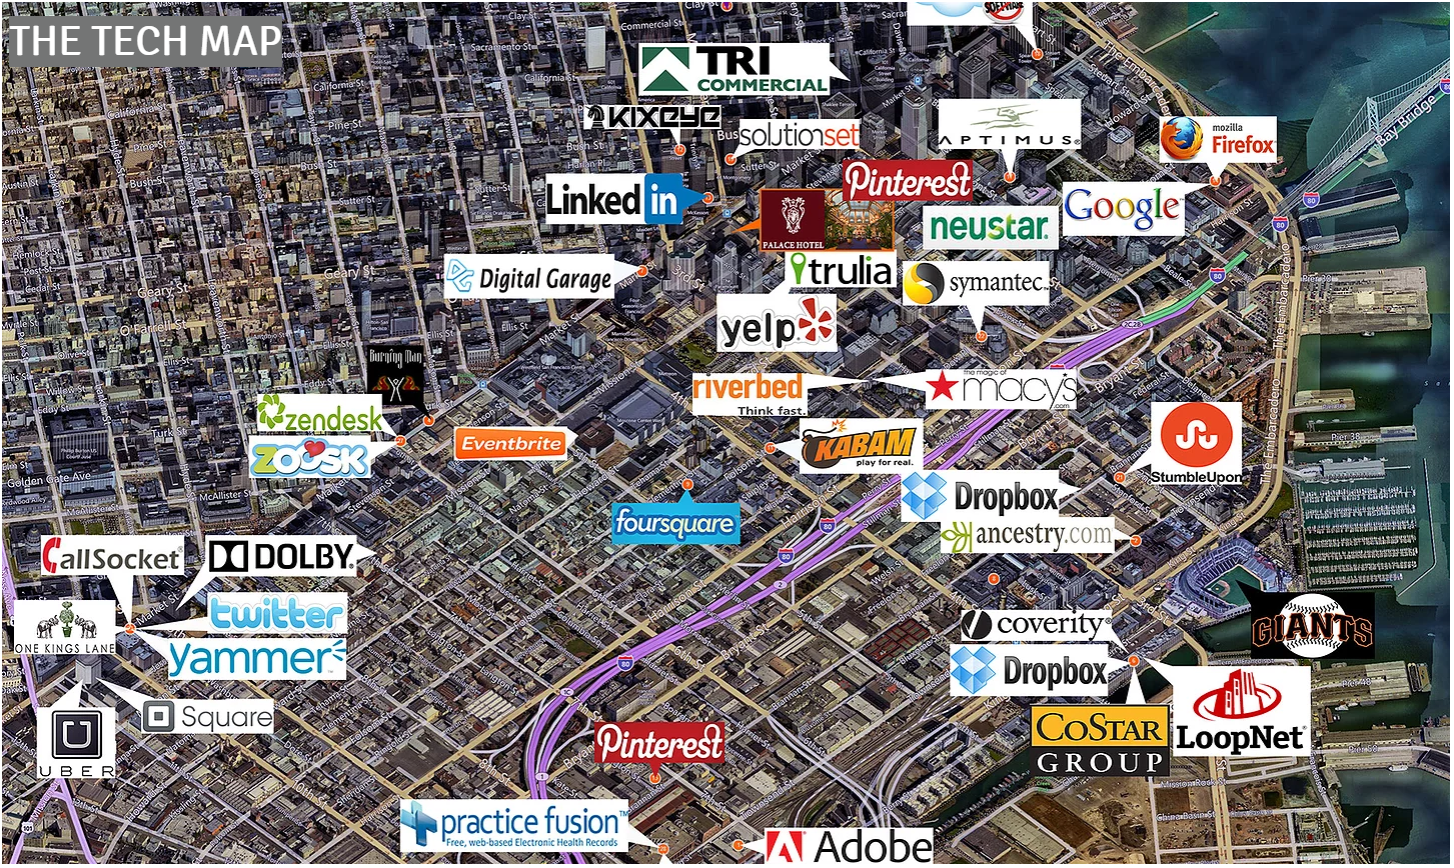

In [12]:
# Sample of tech companies in San Francisco SoMa area (this diagram shows both north and south of Market Street)
# Image source: www.sfhousingservices.com
Image(filename="SF-SoMa-Tech-Map.png", width=800, height=800)

### Seattle Map, Pinpointing Pioneer Square Area (zoom in); and Seattle Pioneer Square Tech Companies Map.

In [13]:
# Display map of the Seattle / Pioneer Square Area
map_SeattlePS = folium.Map(location=[latitude_SeattlePS, longitude_SeattlePS], tiles='Stamen Terrain', zoom_start=12)

folium.Marker(location=[latitude_SeattlePS, longitude_SeattlePS], popup='Seattle').add_to(map_SeattlePS)
folium.CircleMarker(location=[latitude_SeattlePS, longitude_SeattlePS], radius=10,
popup='Seattle / Pioneer Square', color='#3186cc', fill_color='#3186cc').add_to(map_SeattlePS)
map_SeattlePS

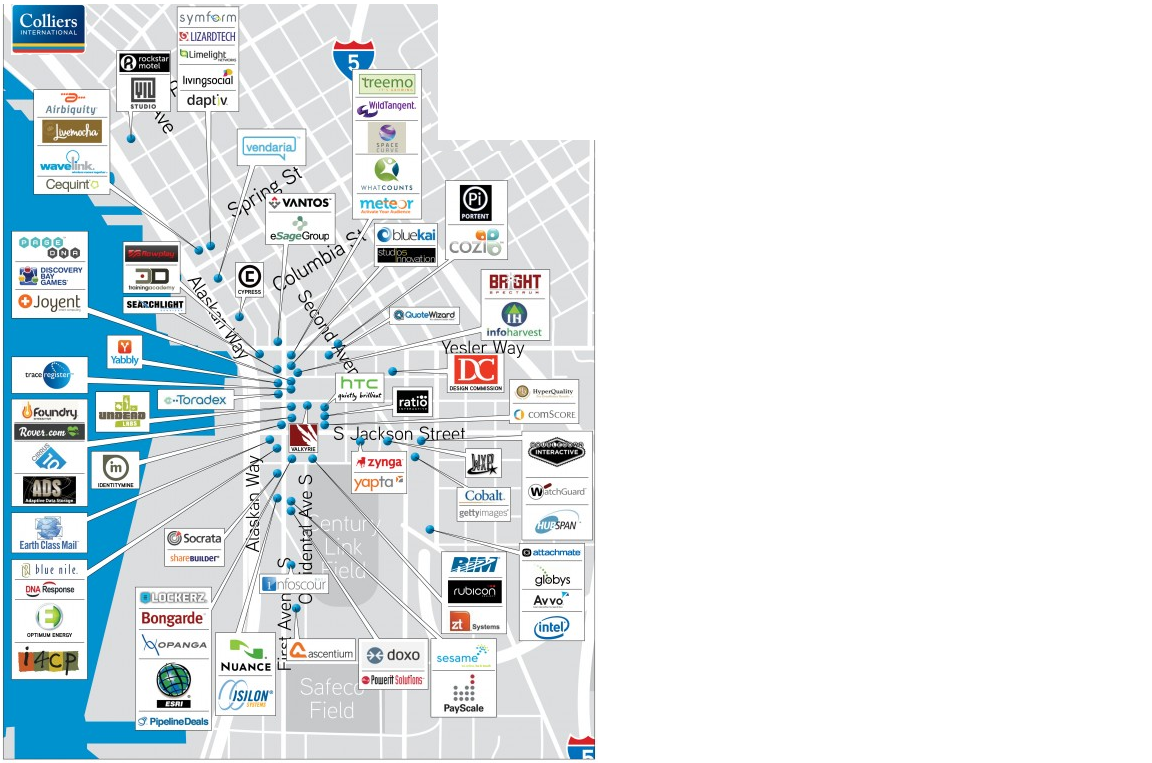

In [14]:
# Sample of tech companies in Seattle Pioneer Square neighborhood
# Image source: Colliers International, referenced at www.geekwire.com
Image(filename="Seattle-Pioneer-Square-Tech-Map.png", width=900, height=900)

### Part 2:  Financial Impact to the Company for Locating in Each Neighborhood: SF SoMa & SEA Pioneer Square.
### Part 2(a): Compare Commercial Real Estate Rental Costs for the Two Neighborhoods.
### 2(a)(1): SF SoMa Commercial Real Estate Prices: Data Collection. First designate the centroid of the San Francisco SoMa neighborhood, then organize the database of currently-available SF SoMa Commercial Real Estate office properties. I constructed this database from three commercial real estate listing websites: cityfeet.com, 42floors.com, loopnet.com; stored the data in an Excel .CSV file. Below I retrieve the .CSV database file and format into a Pandas Dataframe.

In [15]:
# GeoCoders-Nominatum: retrieve Lat-Long coordinates for the San Francisco / SoMa centroid address location.
#  Note: I define the SoMa center (centroid) from an examination of the SF map as: 
#   508 4th St, San Francisco, CA 94107 (coincides with the location of the "Coin-Op Game Room").
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("508 4th St, San Francisco, CA 94107")
sfCommPropertyLat = location.latitude
sfCommPropertyLong = location.longitude

print('Property Address of SF SoMa centroid location (CSV format):\n ', location.address)
print('Lat-Long Coordinates of SF SoMa centroid location:\n ', (sfCommPropertyLat, sfCommPropertyLong))
# print('\nLocation Raw Record Contents:', location.raw,'\n')

Property Address of SF SoMa centroid location (CSV format):
  508, 4th Street, South of Market, SF, California, 94107, USA
Lat-Long Coordinates of SF SoMa centroid location:
  (37.7794001020408, -122.398002938776)


In [16]:
# Access the SF SoMa Commercial Real Estate .CSV file, and structure in a Pandas dataframe for computation
SF_SoMa_CommRE = pd.read_csv(filepath_or_buffer='SF-SOMA-Comm-Real-Estate-Dataset-CSV.csv', sep=',')

SF_SoMa_CommRE.columns = ['Address', 'City', 'State', 'Zip Code', 'Neighborhood', 'Property Sq Ft', 'List Rental Price/Month', 'Price per SqFt/Year', 'Description / Characterization', 'Rent Range (if provided)', 'Listing Website']
SF_SoMa_CommRE['Zip Code'] = SF_SoMa_CommRE['Zip Code'].astype(int)
SF_SoMa_CommRE['Zip Code'] = SF_SoMa_CommRE['Zip Code'].astype(str)
SF_SoMa_CommRE.head(8)

Address           City State Zip Code Neighborhood  \
0  1045 Bryant Street  San Francisco    CA    94103         SoMa   
1  1108 Bryant Street  San Francisco    CA    94103         SoMa   
2  1121 Howard Street  San Francisco    CA    94103         SoMa   
3  1121 Howard Street  San Francisco    CA    94103         SoMa   
4  1159 Howard Street  San Francisco    CA    94103         SoMa   
5  1169 Howard Street  San Francisco    CA    94103         SoMa   
6     123 10th Street  San Francisco    CA    94103         SoMa   
7  1252 Howard Street  San Francisco    CA    94103         SoMa   

  Property Sq Ft List Rental Price/Month Price per SqFt/Year  \
0          4,361             $21,085.00              $60.00    
1          1,351              $3,945.00              $35.04    
2          2,800             $10,500.00              $45.00    
3          2,200             $10,083.33              $55.00    
4          7,220             $25,270.00              $42.00    
5          1,400              $6,244.00              $53.52    
6          6,000             $18,900.00              $37.80    
7          4,500             $20,250.00              $54.00    

  Description / Characterization Rent Range (if provided) Listing Website  
0                         Office                      NaN    cityfeet.com  
1                         Office                      NaN    cityfeet.com  
2                         Office                      NaN    cityfeet.com  
3                         Office                      NaN    cityfeet.com  
4                         Office                      NaN    cityfeet.com  
5                         Office                      NaN    cityfeet.com  
6                         Office                      NaN    cityfeet.com  
7                         Office              54.00-56.00    cityfeet.com

In [17]:
SF_SoMa_CommRE.shape

(64, 11)

### 2(a)(2): SEA Pioneer Square Commercial Real Estate Prices: Data Collection. First designate the centroid of the Seattle Pioneer Square neighborhood, then organize the database of currently-available SEA Pioneer Square Commercial Real Estate office properties. I constructed this database from three commercial real estate listing websites: cityfeet.com, 42floors.com, loopnet.com; stored the data in an Excel .CSV file. Below I retrieve the .CSV database file and format into a Pandas Dataframe.

In [18]:
# GeoCoders-Nominatum retrieves Lat-Long coordinates for the SEA / Pioneer Square centroid address location.
#  Note: I define the Pioneer Square center (centroid), from an examination of the SF map, as:
#   308 Occidental Ave S, Seattle, WA  98104
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("308 Occidental Ave S, Seattle, WA")
SEACommPropertyLat = location.latitude
SEACommPropertyLong = location.longitude

print('Property Address of SEA Pioneer Square centroid location (CSV format):\n ', location.address)
print('Lat-Long Coordinates of SEA Pioneer Square centroid location:\n ', (SEACommPropertyLat, SEACommPropertyLong))
# print('\nLocation Raw Record Contents:', location.raw,'\n')

Property Address of SEA Pioneer Square centroid location (CSV format):
  308, Occidental Avenue South, West Edge, International District/Chinatown, Seattle, King County, Washington, 98104, USA
Lat-Long Coordinates of SEA Pioneer Square centroid location:
  (47.5996938, -122.3326903)


In [19]:
# Access the SEA Pioneer Square Commercial Real Estate .CSV file, and structure in a Pandas dataframe for computation
SEA_PS_CommRE = pd.read_csv(filepath_or_buffer='SEA-PioneerSq-Comm-Real-Estate-Dataset-CSV.csv', sep=',')

SEA_PS_CommRE.columns = ['Address', 'City', 'State', 'Zip Code', 'Neighborhood', 'Property Sq Ft', 'List Rental Price/Month', 'Price per SqFt/Year', 'Description / Characterization', 'Rent Range (if provided)', 'Listing Website']
SEA_PS_CommRE['Zip Code'] = SEA_PS_CommRE['Zip Code'].astype(int)
SEA_PS_CommRE['Zip Code'] = SEA_PS_CommRE['Zip Code'].astype(str)
SEA_PS_CommRE.head(8)

Address     City State Zip Code Neighborhood Property Sq Ft  \
0     675 S Lane Street  Seattle    WA    98104   Pioneer Sq          1,475   
1  308 Occidental Ave S  Seattle    WA    98104   Pioneer Sq          4,258   
2           720 3rd Ave  Seattle    WA    98104   Pioneer Sq          4,404   
3           720 3rd Ave  Seattle    WA    98104   Pioneer Sq          8,505   
4         432 2nd Ave S  Seattle    WA    98104   Pioneer Sq          2,474   
5         432 2nd Ave S  Seattle    WA    98104   Pioneer Sq          2,228   
6         432 2nd Ave S  Seattle    WA    98104   Pioneer Sq          7,608   
7           719 2nd Ave  Seattle    WA    98104   Pioneer Sq          7,177   

  List Rental Price/Month Price per SqFt/Year Description / Characterization  \
0              $2,950.00              $24.00                          Office   
1             $12,774.00              $36.00                          Office   
2             $15,414.00              $42.00                          Office   
3             $29,767.50              $42.00                          Office   
4              $5,772.67              $28.00                          Office   
5              $6,776.83              $36.50                          Office   
6             $24,409.00              $38.50                          Office   
7             $27,118.00              $34.00                          Office   

  Rent Range (if provided) Listing Website  
0                      NaN    cityfeet.com  
1                      NaN    cityfeet.com  
2                      NaN    cityfeet.com  
3                      NaN    cityfeet.com  
4                      NaN    cityfeet.com  
5                      NaN    cityfeet.com  
6                      NaN    cityfeet.com  
7              34.00-36.00    cityfeet.com

In [20]:
SEA_PS_CommRE.shape

(36, 11)

### Plot the histogram for each neighborhood's commercial real estate prices: calculates and displays the mean and distribution of current commercial real estate prices. Then visually compare these by plotting boxplots of the real estate pricing data distributions side-by-side.

In [21]:
# Plot the SF SoMa Commercial Real Estate rental prices in a histogram
# Prices = values of 'Price per SqFt/Year' column, from the SF_SoMa Comm R.E. properties referenced in the .CSV file
y_SFCommRE = SF_SoMa_CommRE['Price per SqFt/Year'].sort_values(ascending=True)
y_SFCommRE = y_SFCommRE.replace('[\$,]', '', regex=True).astype(float)
y_SFCommRE = y_SFCommRE.values
x_UnitSeries = np.arange(1, (len(y_SFCommRE)+1), 1)
# print('y_SFCommRE array = \n', y_SFCommRE)
# print('\nx_UnitSeries array = \n', x_UnitSeries)

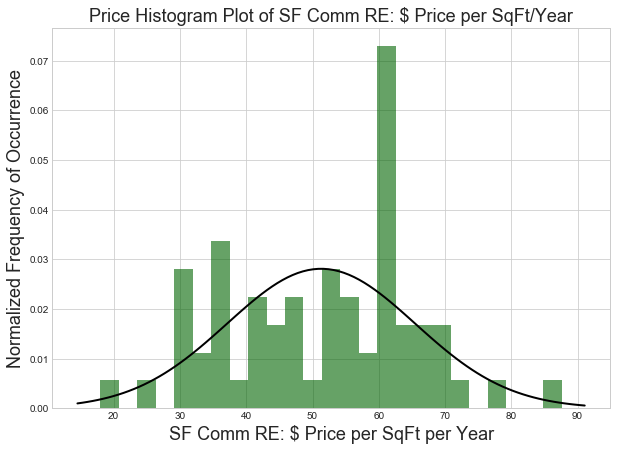

Mean    SF Commercial Real Estate Price: $ per SqFt per Year = $ 51.30
Median  SF Commercial Real Estate Price: $ per SqFt per Year = $ 53.82
Std Dev SF Commercial Real Estate Price: $ per SqFt per Year = $ 14.20

Note to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for 
  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.


In [22]:
# Fit a normal distribution to the data:
rcParams['figure.figsize'] = 10, 7
mu, std = norm.fit(y_SFCommRE)
# Plot the histogram (the vertical colored bars).
plt.hist(y_SFCommRE, bins=25, density=True, alpha=0.6, color='darkgreen')
# Plot the Probability Density Function (PDF) (smoothed black curve line).
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

plt.xlabel('SF Comm RE: $ Price per SqFt per Year', fontsize=18)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=18)
plt.title('Price Histogram Plot of SF Comm RE: $ Price per SqFt/Year', fontsize=18)
plt.show()

print("Mean    SF Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.mean(y_SFCommRE)))
print("Median  SF Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.median(y_SFCommRE)))
print("Std Dev SF Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.std(y_SFCommRE)))
print("\nNote to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for \n  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.")

In [23]:
# Plot the SEA Pioneer Square Comercial Real Estate rental prices in a histogram
# Values of 'Price per SqFt/Year' column, from Seattle / Pioneer Square Comm R.E. properties referenced in the .CSV file
y_SEACommRE = SEA_PS_CommRE['Price per SqFt/Year'].sort_values(ascending=True)
y_SEACommRE = y_SEACommRE.replace('[\$,]', '', regex=True).astype(float)
y_SEACommRE = y_SEACommRE.values
x_UnitSeries = np.arange(1, (len(y_SEACommRE)+1), 1)
# print('y_SEACommRE array = \n', y_SEACommRE)
# print('\nx_UnitSeries array = \n', x_UnitSeries)

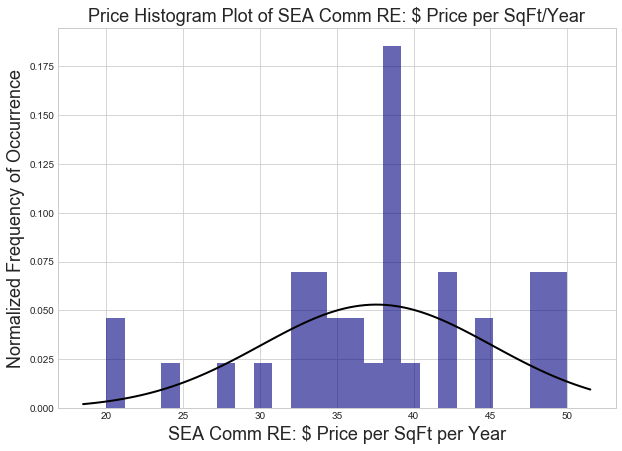

Mean    SEA Commercial Real Estate Price: $ per SqFt per Year = $ 37.58
Median  SEA Commercial Real Estate Price: $ per SqFt per Year = $ 38.00
Std Dev SEA Commercial Real Estate Price: $ per SqFt per Year = $  7.53

Note to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for 
  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.


In [24]:
# Fit a normal distribution to the data:
rcParams['figure.figsize'] = 10, 7
mu, std = norm.fit(y_SEACommRE)
# Plot the histogram (the vertical colored bars).
plt.hist(y_SEACommRE, bins=25, density=True, alpha=0.6, color='navy')
# Plot the Probability Density Function (PDF) (the smoothed black curve line).
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

plt.xlabel('SEA Comm RE: $ Price per SqFt per Year', fontsize=18)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=18)
plt.title('Price Histogram Plot of SEA Comm RE: $ Price per SqFt/Year', fontsize=18)
plt.show()

print("Mean    SEA Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.mean(y_SEACommRE)))
print("Median  SEA Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.median(y_SEACommRE)))
print("Std Dev SEA Commercial Real Estate Price: $ per SqFt per Year = $  "+"{:.2f}".format(np.std(y_SEACommRE)))
print("\nNote to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for \n  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.")

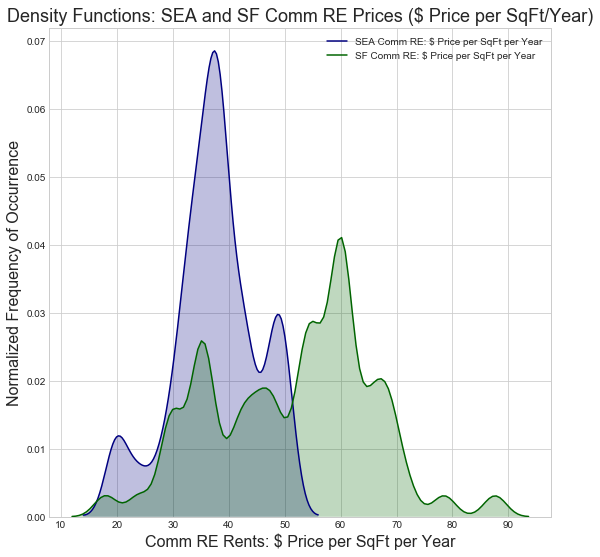

In [25]:
rcParams['figure.figsize'] = 9,9
sns.kdeplot(y_SEACommRE, bw=2, color='navy', shade=True, label="SEA Comm RE: $ Price per SqFt per Year")
sns.kdeplot(y_SFCommRE, bw=2, color = 'darkgreen', shade=True, label="SF Comm RE: $ Price per SqFt per Year")

plt.xlabel('Comm RE Rents: $ Price per SqFt per Year', fontsize=16)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=16)
plt.title('Density Functions: SEA and SF Comm RE Prices ($ Price per SqFt/Year)', fontsize=18)
plt.show()

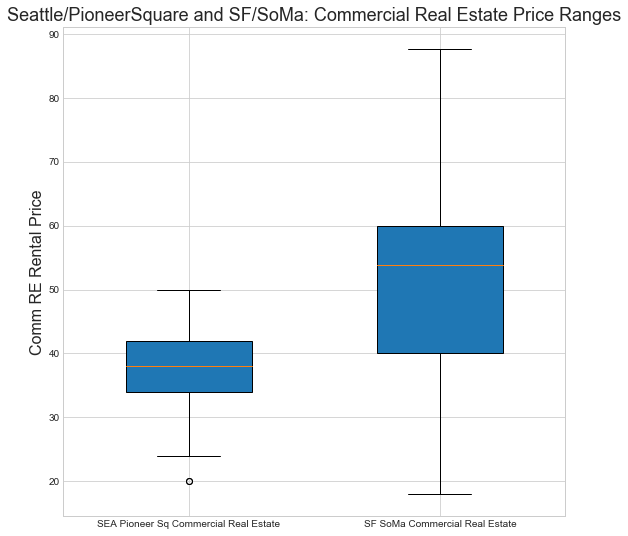

In [26]:
# Generate boxplots of both SF and SEA to show and compare the Comm RE value distributions
# First build the Pandas dataframe with the two neighborhoods, showing the span of Comm RE rental prices for each
#  Result: 2-column dataframe: ['SF_SoMa_Comm_RE', 'SEA_PS_Comm_RE']

rcParams['figure.figsize'] = 9, 9

fig = plt.figure()
plt.title('Seattle/PioneerSquare and SF/SoMa: Commercial Real Estate Price Ranges', fontsize=18)
plt.ylabel('Comm RE Rental Price', fontsize=16)
box_plot_data = [y_SEACommRE, y_SFCommRE]
plt.boxplot(box_plot_data, patch_artist = True, labels = ['SEA Pioneer Sq Commercial Real Estate', 'SF SoMa Commercial Real Estate'], widths=(0.5, 0.5))
plt.show()

### Part 2(b): Business Density Calculation using DBSCAN clustering: Density Based Clustering for Applications with Noise.
### 2(b)(1): SF SoMa Neighborhood Business Density Calculations: first we access the Foursquare database to retrieve San Francisco / SoMa District venues within a 1600 meter radius (1 mile radius) from the centroid of the region, then we cluster them by geographical proximity.

In [27]:
# Note: this is the cell where I provide my Foursquare confidential customer credentials
# My confidential Foursquare customer credentials are REDACTED here.

VERSION = '20180605'  # Foursquare API version
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL
CLIENT_SECRET: OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI


In [28]:
# Access the Foursquare database for San Francisco / SoMa local businesses
# Analyze venues / local businesses within 1600 meters of the target neighborhood (approx. 1-mile radius)
latitude_SFSoMa = 37.779190
longitude_SFSoMa = -122.398102
radius = 1600
limit = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude_SFSoMa, longitude_SFSoMa, radius, limit)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL&client_secret=OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI&v=20180605&ll=37.77919,-122.398102&radius=1600&limit=100'

In [29]:
results_SF = requests.get(url).json()
# results_SF

In [30]:
# Print selected Venue Name results, to verify the Foursquare JSON object referencing.
print('San Francisco / SoMa Neighborhood - first listed venue name and its formatted address:')
# results_SF['response']['groups'][0]['items'][0]['venue']['name'] --> SFJazz Center
print(results_SF['response']['groups'][0]['items'][0]['venue']['name'], ', ', results_SF['response']['groups'][0]['items'][0]['venue']['location']['formattedAddress'],'\n')

print('San Francisco / SoMa Neighborhood - first 10 listed venue names:')
for i in range(10):
    print(results_SF['response']['groups'][0]['items'][i]['venue']['name'])

San Francisco / SoMa Neighborhood - first listed venue name and its formatted address:
K&L Wine Merchants ,  ['855 Harrison St (btwn 4th and 5th St)', 'San Francisco, CA 94107', 'United States'] 

San Francisco / SoMa Neighborhood - first 10 listed venue names:
K&L Wine Merchants
Marlowe
Cockscomb
Darwin Cafe
Bamboo Reef Scuba Diving Centers
Bay Club SF Tennis
United Barbell - CrossFit
Garaje
HWA RANG KWAN Martial Arts Center
Coin-Op Game Room


In [31]:
# Clean the JSON object and structure it into a pandas dataframe.
search_query_SF = 'venues'
nearby_venues_SF = results_SF['response']['groups'][0]['items']
# nearby_venues_SF[:3]
nearby_venues_SF = json_normalize(nearby_venues_SF)     # flatten JSON
# nearby_venues_SF.head()

# print(nearby_venues_SF.loc[0, ['venue.categories'][0]], '\n')
# print(nearby_venues_SF.loc[1, ['venue.categories'][0]], '\n')

# for i in range(10):
#     print(nearby_venues_SF.loc[i, ['venue.categories'][0]], '\n')
# nearby_venues_SF.shape

# nearby_venues_SF.loc[0:9, ['venue.name', 'venue.categories', 'referralId']]
df_SF = getNearbyVenues('SF_SoMa', latitude_SFSoMa, longitude_SFSoMa, radius)
df_SF.head(10)

Location                         Venue Name   Latitude   Longitude  \
0  SF_SoMa                 K&L Wine Merchants  37.779678 -122.400807   
1  SF_SoMa                            Marlowe  37.778289 -122.396685   
2  SF_SoMa                          Cockscomb  37.778578 -122.397395   
3  SF_SoMa                        Darwin Cafe  37.780669 -122.396115   
4  SF_SoMa   Bamboo Reef Scuba Diving Centers  37.778471 -122.396795   
5  SF_SoMa                 Bay Club SF Tennis  37.776571 -122.397948   
6  SF_SoMa          United Barbell - CrossFit  37.777718 -122.395331   
7  SF_SoMa                             Garaje  37.781745 -122.396151   
8  SF_SoMa                  Coin-Op Game Room  37.779274 -122.398032   
9  SF_SoMa  HWA RANG KWAN Martial Arts Center  37.779445 -122.397300   

                  Category  
0                Wine Shop  
1  New American Restaurant  
2  New American Restaurant  
3                     Café  
4                Dive Shop  
5             Tennis Court  
6                      Gym  
7       Mexican Restaurant  
8                   Arcade  
9        Martial Arts Dojo

In [32]:
nearby_venues_SF.shape

(100, 28)

In [33]:
df_SF.shape

(100, 5)

In [34]:
# Generate map of San Francisco venues in the proximity of SoMa Center using latitude and longitude values
map_SoMa_venues = folium.Map(location=[latitude_SFSoMa, longitude_SFSoMa], zoom_start=15)
mapMarkers(map_SoMa_venues, df_SF)
map_SoMa_venues

### Conduct DBSCAN spatial clustering for these venues: Density-Based Spatial Clustering for Applications with Noise

In [35]:
X_df_SF = df_SF.drop(['Location','Venue Name', 'Category'],axis=1)
X_df_SF.head()

Latitude   Longitude
0  37.779678 -122.400807
1  37.778289 -122.396685
2  37.778578 -122.397395
3  37.780669 -122.396115
4  37.778471 -122.396795

In [36]:
# DBSCAN Clustering: Density-Based Spatial Clustering for Applications with Noise

# First, generate the key two parameters for the DBSCAN Clustering: 
#  minPoints: minimum number of points per cluster
#  epsilon: proximity ratio 
minPoints = 7
eps = epsilon(X_df_SF, minPoints)

# Next, call the DBSCAN clustering algorithm and extract the DBSCAN Cluster Labels
dbscan_SoMaVenues = DBSCAN(eps, minPoints).fit(X_df_SF)
df_SF['Cluster Labels'] = dbscan_SoMaVenues.labels_

print('DBSCAN epsilon (eps)  = ', eps, '\n')
print('DBSCAN Object for SF SoMa Venues  = dbscan_SoMaVenues:\n', dbscan_SoMaVenues, '\n')
print('DBSCAN Cluster Labels  = dbscan_SoMaVenues.labels_:\n', dbscan_SoMaVenues.labels_, '\n')

DBSCAN epsilon (eps)  =  0.0027569011253859173 

DBSCAN Object for SF SoMa Venues  = dbscan_SoMaVenues:
 DBSCAN(algorithm='auto', eps=0.0027569011253859173, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=7, n_jobs=1,
    p=None) 

DBSCAN Cluster Labels  = dbscan_SoMaVenues.labels_:
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  0  0 -1  0  0 -1  0
  1  0  0  0  1  0  1  0 -1  1  1  0 -1  1  0  1  1  1  1  1  1  1  1  1
  2  1  2  1  0  1  1  1  1  2  1  1 -1  1  1  1  1  1  1  2  1  1 -1  1
  1 -1  1  1 -1  2  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1  1  2  1  1  1
  1 -1  1  1] 



In [37]:
# Now count the number of clustered labels, and count the number of outliers
df_SF.groupby('Cluster Labels').size().sort_values()

Cluster Labels
 2     6
-1    13
 0    25
 1    56
dtype: int64

In [38]:
# Plot DBSCAN results with Folium
map_clusters = folium.Map(location=[latitude_SFSoMa, longitude_SFSoMa], zoom_start=15)
clustersNum = (np.max(dbscan_SoMaVenues.labels_)) + 1
print("clustersNum = ", clustersNum)

clustersNum =  3


In [39]:
clusterMap(clustersNum, df_SF)
map_clusters

### Part 2(b)(1) Conclusion for San Francisco: the Business Density Ratio for San Francisco / SoMa Region = 0.87, as calculated below.

In [40]:
num_SF_clustered = ((df_SF['Cluster Labels'] == 0).sum()) + ((df_SF['Cluster Labels'] == 1).sum()) + ((df_SF['Cluster Labels'] == 2).sum())
venues_density_SFSoMa = (num_SF_clustered/100)
print("The business venues density ratio for San Francisco / SoMa neighborhood is: ", venues_density_SFSoMa)

The business venues density ratio for San Francisco / SoMa neighborhood is:  0.87


### --  Now repeat the above business density analysis for the Seattle / Pioneer Square neighborhood  --
### Part 2(b)(2): Seattle / Pioneer Square Neighborhood Business Density Calculations: first we access the Foursquare database to retrieve SEA / Pioneer Square venues within a 1600 meter radius (1 mile radius) from the centroid of the region, then we cluster them by geographical proximity.

In [42]:
# Access the Foursquare database for Seattle / Pioneer Square local businesses
# Analyze venues / local businesses within 1600 meters of the target neighborhood (approx. 1-mile radius)
latitude_SeattlePS = 47.601954
longitude_SeattlePS = -122.329204
radius = 1600
limit = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude_SeattlePS, longitude_SeattlePS, radius, limit)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL&client_secret=OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI&v=20180605&ll=47.601954,-122.329204&radius=1600&limit=100'

In [43]:
results_SEA = requests.get(url).json()
# results_SEA

In [44]:
# Print selected Venue Name results, to verify the Foursquare JSON object referencing.

print('Seattle / Pioneer Square Neighborhood - first listed venue name and its formatted address:')
# results_SEA['response']['groups'][0]['items'][0]['venue']['name']  --> 'Il Corvo'
print(results_SEA['response']['groups'][0]['items'][0]['venue']['name'], ', ', results_SEA['response']['groups'][0]['items'][0]['venue']['location']['formattedAddress'],'\n')

print('Seattle / Pioneer Square Neighborhood - first 10 listed venue names:')
for i in range(10):
    print(results_SEA['response']['groups'][0]['items'][i]['venue']['name'])

Seattle / Pioneer Square Neighborhood - first listed venue name and its formatted address:
Il Corvo ,  ['217 James St (btwn 2nd & 3rd Ave)', 'Seattle, WA 98104', 'United States'] 

Seattle / Pioneer Square Neighborhood - first 10 listed venue names:
Il Corvo
Elm Coffee Roasters
Biscuit B*tch
Tat's Delicatessen
Flatstick Pub
Tsukushinbo
Cherry Street Public House
Columbia Tower Club
Juicy Cafe
Smith Tower


In [45]:
# Clean the JSON object and structure it into a pandas dataframe.
search_query_SEA = 'venues'
nearby_venues_SEA = results_SEA['response']['groups'][0]['items']
# nearby_venues_SEA[:3]
nearby_venues_SEA = json_normalize(nearby_venues_SEA)  # flatten JSON
# nearby_venues_SEA.head()

# nearby_venues_SEA.loc[0:3, ['referralId']]
# nearby_venues_SEA.loc[0:3, ['referralId', 'venue.name', 'venue.categories']]

# print(nearby_venues_SEA.loc[0, ['venue.categories'][0]], '\n')
# print(nearby_venues_SEA.loc[1, ['venue.categories'][0]], '\n')

# for i in range(10):
#     print(nearby_venues_SEA.loc[i, ['venue.categories'][0]], '\n')

# nearby_venues_SEA.loc[0:9, ['referralId', 'venue.name', 'venue.categories']]
df_SEA = getNearbyVenues('SEA_PioneerSq', latitude_SeattlePS, longitude_SeattlePS, radius)
df_SEA.head(10)

Location                  Venue Name   Latitude   Longitude  \
0  SEA_PioneerSq                    Il Corvo  47.602522 -122.331952   
1  SEA_PioneerSq         Elm Coffee Roasters  47.600152 -122.330944   
2  SEA_PioneerSq               Biscuit B*tch  47.603237 -122.332010   
3  SEA_PioneerSq          Tat's Delicatessen  47.601901 -122.332423   
4  SEA_PioneerSq               Flatstick Pub  47.600220 -122.331310   
5  SEA_PioneerSq                 Tsukushinbo  47.599963 -122.326878   
6  SEA_PioneerSq  Cherry Street Public House  47.600450 -122.332908   
7  SEA_PioneerSq         Columbia Tower Club  47.604507 -122.330484   
8  SEA_PioneerSq                  Juicy Cafe  47.604329 -122.330958   
9  SEA_PioneerSq                 Smith Tower  47.601858 -122.332152   

              Category  
0   Italian Restaurant  
1          Coffee Shop  
2       Breakfast Spot  
3       Sandwich Place  
4             Beer Bar  
5  Japanese Restaurant  
6          Coffee Shop  
7          Social Club  
8                 Café  
9             Building

In [46]:
nearby_venues_SEA.shape

(100, 28)

In [47]:
df_SEA.shape

(100, 5)

In [48]:
# Generate map of Seattle venues in the proximity of Pioneer Square using latitude and longitude values
map_SEA_venues = folium.Map(location=[latitude_SeattlePS, longitude_SeattlePS], zoom_start=15)
mapMarkers(map_SEA_venues, df_SEA)
map_SEA_venues

In [49]:
X_df_SEA = df_SEA.drop(['Location','Venue Name', 'Category'],axis=1)
X_df_SEA.head()

Latitude   Longitude
0  47.602522 -122.331952
1  47.600152 -122.330944
2  47.603237 -122.332010
3  47.601901 -122.332423
4  47.600220 -122.331310

In [50]:
# DBSCAN Clustering: Density-Based Spatial Clustering for Applications with Noise

# First, generate the key two parameters for the DBSCAN Clustering: 
#  minPoints: minimum number of points per cluster
#  epsilon: proximity ratio 
minPoints = 7
eps = epsilon(X_df_SEA, minPoints)

# Next, call the DBSCAN clustering algorithm and extract the DBSCAN Cluster Labels
dbscan_SEA_PS_Venues = DBSCAN(eps, minPoints).fit(X_df_SEA)
df_SEA['Cluster Labels'] = dbscan_SEA_PS_Venues.labels_

print('DBSCAN epsilon (eps)  = ', eps, '\n')
print('DBSCAN Object for SEA Pioneer Square Venues  = dbscan_SEA_PS_Venues:\n', dbscan_SEA_PS_Venues, '\n')
print('DBSCAN Cluster Labels  = dbscan_SEA_PS_Venues.labels_:\n', dbscan_SEA_PS_Venues.labels_, '\n')

DBSCAN epsilon (eps)  =  0.0031118670658330507 

DBSCAN Object for SEA Pioneer Square Venues  = dbscan_SEA_PS_Venues:
 DBSCAN(algorithm='auto', eps=0.0031118670658330507, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=7, n_jobs=1,
    p=None) 

DBSCAN Cluster Labels  = dbscan_SEA_PS_Venues.labels_:
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  1
  1  0  0  0  1  0  0  0  0  1  0  0  1  0 -1 -1  0 -1  0 -1  0  0  0  0
  1  0  0  0  0  0  2  0  0  0  2  2  0  0  1  0  0  0  0  0  0  0 -1  2
  0 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  2  2  0  0  2  0  0  0  0
  0  0  0  0] 



In [51]:
df_SEA.groupby('Cluster Labels').size().sort_values()

Cluster Labels
-1     7
 2     7
 1    10
 0    76
dtype: int64

In [52]:
map_clusters = folium.Map(location=[latitude_SeattlePS, longitude_SeattlePS], zoom_start=15)
clustersNum = np.max(dbscan_SEA_PS_Venues.labels_) + 1
print("clustersNum = ", clustersNum)

clustersNum =  3


In [53]:
clusterMap(clustersNum, df_SEA)
map_clusters

### Part 2(b)(2): Conclusion for Seattle: the Business Density Ratio for Seattle / Pioneer Square region = 0.93, as calculated below.

In [54]:
num_SEA_clustered = ((df_SEA['Cluster Labels'] == 0).sum()) + ((df_SEA['Cluster Labels'] == 1).sum()) + ((df_SEA['Cluster Labels'] == 2).sum())
venues_density_SEA_PS = (num_SEA_clustered/100)
print("The business venues density ratio for Seattle / Pioneer Square neighborhood is: ", venues_density_SEA_PS)

The business venues density ratio for Seattle / Pioneer Square neighborhood is:  0.93


### Part 2(c): State and City Corporate Income Taxes Assessment.
I calculate the C corporation tax impact for two company financial profiles for each neighborhood: 

(1) A company with $2M annual revenue and 15% Net Income Before Taxes.

(2) A company with $10M annual revenue and 15% Net Income Before Taxes.

### 2(c)(1): State of California / City of San Francisco Corporate Tax Structure:
- State of California business tax rate = 8.84% on Corporate Net Income
- San Francisco Corporate Gross Receipts Tax: scales with sales revenues; 0.46% for \$2M sales, 0.51% for \$10M sales.
- San Francisco Payroll Expense Tax = 0.38%, for corporate entities with a personnel payroll exceeding $300K/year.

### 2(c)(2): State of Washington / City of Seattle Corporate Tax Structure:
- State of Washington business tax rate: 1.5% on Corporate Net Income
- Seattle City Gross Receipts Tax: 0.427% on Gross Receipts.

In [55]:
# Access the .CSV file describing tax structures for California/San Francisco and Washington/Seattle, 
#  and structure in a Pandas dataframe for computation
bizTaxes_SanFran_Seattle = pd.read_csv(filepath_or_buffer='Corporate-Taxes-Scenarios-SFSoMa-and-SeattlePS.csv', sep=',')
bizTaxes_SanFran_Seattle.columns = ['Corporate Item', 'Corp Financial Result', 'CA State Corp Tax', 'SF: Gross Receipts Tax', 'SF: Payroll Expense Tax', 'CA/SF Tax Computation', 'WA State Corp Tax', 'Seattle City Tax', 'WA/Seattle Tax Computation']
bizTaxes_SanFran_Seattle

Corporate Item Corp Financial Result  \
0                      Corp Sales @ $2M           $2,000,000    
1        Payroll Expense @ 50% of Sales           $1,000,000    
2      Profit Before Tax @ 15% of Sales             $300,000    
3                       Tax Computation                   $0    
4                     Corp Sales @ $10M          $10,000,000    
5        Payroll Expense @ 50% of Sales           $5,000,000    
6      Profit Before Tax @ 15% of Sales           $1,500,000    
7                       Tax Computation                   $0    

  CA State Corp Tax SF: Gross Receipts Tax SF: Payroll Expense Tax  \
0                 0                  0.46%                       0   
1                 0                      0                   0.38%   
2             8.84%                      0                       0   
3                 0                      0                       0   
4                 0                  0.51%                       0   
5                 0                      0                   0.38%   
6             8.84%                      0                       0   
7                 0                      0                       0   

  CA/SF Tax Computation WA State Corp Tax Seattle City Tax  \
0                   $0                  0            0.43%   
1                   $0                  0                0   
2                   $0              1.50%                0   
3              $39,520                  0                0   
4                   $0                  0            0.43%   
5                   $0                  0                0   
6                   $0              1.50%                0   
7             $202,600                  0                0   

  WA/Seattle Tax Computation  
0                        $0   
1                        $0   
2                        $0   
3                   $13,040   
4                        $0   
5                        $0   
6                        $0   
7                   $65,200

### Generate a multi-bar chart -- corporate tax computations for each of: \$2M company and \$10M company

In [56]:
# Dataframe.loc[["row1", "row2"], ["column1", "column2", "column3"]]
bizTaxes_df = pd.DataFrame(bizTaxes_SanFran_Seattle[['Corporate Item', 'Corp Financial Result', 'CA/SF Tax Computation', 'WA/Seattle Tax Computation']])
bizTaxes_df = bizTaxes_df.iloc[[0,3,4,7],:]
bizTaxes_df.iloc[0,2:4] = bizTaxes_df.iloc[1, 2:4]
bizTaxes_df.iloc[2,2:4] = bizTaxes_df.iloc[3, 2:4]
bizTaxes_df = bizTaxes_df.iloc[[0, 2],:]
bizTaxes_df

Corporate Item Corp Financial Result CA/SF Tax Computation  \
0   Corp Sales @ $2M           $2,000,000               $39,520    
4  Corp Sales @ $10M          $10,000,000              $202,600    

  WA/Seattle Tax Computation  
0                   $13,040   
4                   $65,200

In [57]:
bizTaxes_df['Corp Financial Result'] = bizTaxes_df['Corp Financial Result'].replace('[\$,]', '', regex=True).astype(int)
bizTaxes_df['CA/SF Tax Computation'] = bizTaxes_df['CA/SF Tax Computation'].replace('[\$,]', '', regex=True).astype(int)
bizTaxes_df['WA/Seattle Tax Computation'] = bizTaxes_df['WA/Seattle Tax Computation'].replace('[\$,]', '', regex=True).astype(int)

bizTaxes_df = bizTaxes_df.reset_index(drop=True)
bizTaxes_df

Corporate Item  Corp Financial Result  CA/SF Tax Computation  \
0   Corp Sales @ $2M                2000000                  39520   
1  Corp Sales @ $10M               10000000                 202600   

   WA/Seattle Tax Computation  
0                       13040  
1                       65200

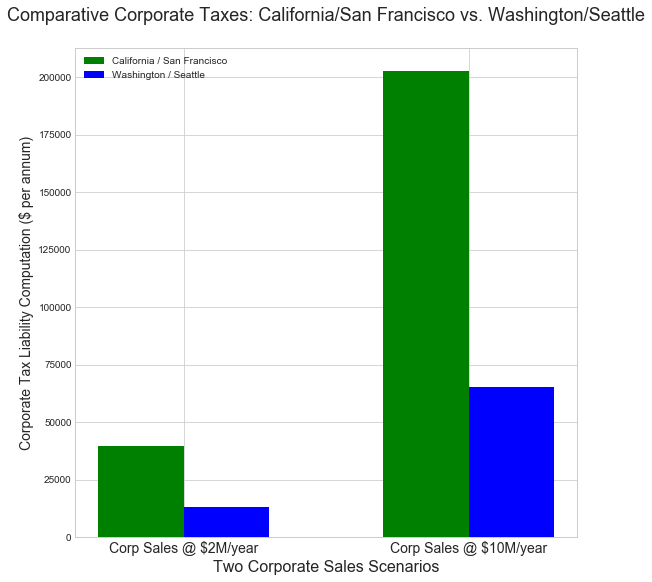

In [58]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
rcParams['figure.figsize'] = 9, 9

ax.bar(index, bizTaxes_df['CA/SF Tax Computation'], bar_width, color='g', label='California / San Francisco')
ax.bar(index+bar_width, bizTaxes_df['WA/Seattle Tax Computation'], bar_width, color='b', label='Washington / Seattle')

ax.set_xlabel('Two Corporate Sales Scenarios', fontsize=16)
ax.set_ylabel('Corporate Tax Liability Computation ($ per annum)', fontsize=14)
ax.set_title('Comparative Corporate Taxes: California/San Francisco vs. Washington/Seattle\n', fontsize=18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Corp Sales @ $2M/year','Corp Sales @ $10M/year'], fontsize=14)
ax.legend()
plt.show()

### Part 3: Employee Quality of Life opportunities for each neighborhood.
###  Part 3(a): Access to Public Rail Transportation. 
### 3(a)(1): Evaluate Ease of Public Transportation Access in the SF SoMa Neighborhood for the Selected Commercial Real Estate Properties. Calculate mean and median distances from the SF Commercial Real Estate available properties to the nearest BART rail public transportation station.

In [59]:
# Display first record for the commercial real estate property file: SF_SoMa_CommRE -- Pandas dataframe
SF_SoMa_CommRE[0:1]

Address           City State Zip Code Neighborhood  \
0  1045 Bryant Street  San Francisco    CA    94103         SoMa   

  Property Sq Ft List Rental Price/Month Price per SqFt/Year  \
0          4,361             $21,085.00              $60.00    

  Description / Characterization Rent Range (if provided) Listing Website  
0                         Office                      NaN    cityfeet.com

In [60]:
# SF Commercial Properties locations
# Display first record for the commercial real estate property file: SF_SoMa_CommRE -- build CSV address location for geocoder
geocode_location = (SF_SoMa_CommRE.iloc[0, 0] + ',' + SF_SoMa_CommRE.iloc[0, 1] + ',' + SF_SoMa_CommRE.iloc[0, 2] + ',' + SF_SoMa_CommRE.iloc[0, 3])

# GeoCoders-Nominatum: retrieve Lat-Long coordinates for first Comm RE property (from .CSV file)
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("1045 Bryant St, San Francisco, CA 94103")
sfCommPropertyLat = location.latitude
sfCommPropertyLong = location.longitude

print('Formatted address geocode_location, for first SF SoMa Comm RE record value (in CSV format) =\n ', geocode_location)
print('Property Address (CSV format):\n ', location.address)
print('Lat-Long Coordinates:\n ', (sfCommPropertyLat, sfCommPropertyLong))
# print('\nLocation Raw Record Contents:', location.raw,'\n')

Formatted address geocode_location, for first SF SoMa Comm RE record value (in CSV format) =
  1045 Bryant Street,San Francisco,CA,94103
Property Address (CSV format):
  DroneDeploy, Cambria Gallery, and Symphony Commerce, 1045, Bryant Street, West SoMa, SF, California, 94103, USA
Lat-Long Coordinates:
  (37.77179775, -122.4073896)


In [61]:
# Below is code I wrote to generate Lat-Long coordinates for the published SF Comm RE data, and stored this in a .csv file. 
#  Then I use the SF Comm RE Lat-Long coordinates to generate the distance from each of these properties to the nearest
#  public transportation station, specifically to the nearest SF BART train transit station in the SF SoMa District.

# Methodology: offline I generated the array of San Francisco Commercial Real Estate listed locations' latitude-longitude coordinates
#  from data I compiled and generated from published Comm RE data: 'SF-SOMA-Comm-Real-Estate-Dataset-CSV.csv',
#  and stored into the Pandas dataframe: SF_SoMa_CommRE. Then I ran these SF_SoMa_CommRE addresses through the geocode_location
#  package to generate the SFCommRE_LatLongArray NumPy array of Lat-Long data pairs, matched by index to each of the 
#  SF_SoMa_CommRE SF Comm RE properties.

# Below I show the code I used to generate this, and then just show the end NumPy array result: SFCommRE_LatLongArray
#  (because running all the addresses through geocode_location takes a long time, approx. 1-2 minutes)
'''
SFCommRE_LatLongArray = np.zeros(shape=((len(SF_SoMa_CommRE)),2))
for i in range(len(SF_SoMa_CommRE)):
    geocode_location = (SF_SoMa_CommRE.iloc[i, 0] + ',' + SF_SoMa_CommRE.iloc[i, 1] + ',' + SF_SoMa_CommRE.iloc[i, 2] + ',' + SF_SoMa_CommRE.iloc[i, 3])
    location = geolocator.geocode(geocode_location)
    # print('i = ', i, '; LocName = ', SF_SoMa_CommRE.iloc[i, 0],';  Location Lat & Long: ', location.latitude, location.longitude)
    SFCommRE_LatLongArray[i] = [location.latitude, location.longitude]

print('\nSFCommRE_LatLongArray: \n', SFCommRE_LatLongArray)
np.savetxt("SFCommRE_LatLongArray.csv", SFCommRE_LatLongArray, delimiter=",")
# df.to_csv("SFCommRE_LatLongArray.csv", sep=',', index=False)
'''
SFCommRE_LatLongArray = genfromtxt('SFCommRE_LatLongArray.csv', delimiter=',')
print('Printing first 4 rows of SF Commercial Real Estate Lat-Long Array:\n', SFCommRE_LatLongArray[0:4,:])

Printing first 4 rows of SF Commercial Real Estate Lat-Long Array:
 [[  37.77179775 -122.4073896 ]
 [  37.77119678 -122.40879967]
 [  37.7774363  -122.40965543]
 [  37.7774363  -122.40965543]]


### Calculate the distance from each commercial real estate property to the nearest BART rail station.

In [62]:
# Retrieve San Francisco BART station information for the Civic Center Station by accessing the SF BART API
# Of the three BART stations near the SF SoMa district, I selected the Civic Center Station because it has 
#   the lowest average distance to all SF Commercial Real Estate properties in this study.

# San Francisco BART API Key Here
# Please Note: I have redacted the confidential SF BART API Key here
sf_BART_Key = 'ZZML-PAYP-9NPT-DWE9'
sf_BART_URL = 'http://api.bart.gov/api/stn.aspx?cmd=stninfo&orig=civc&key=ZZML-PAYP-9NPT-DWE9&json=y'

In [63]:
sfBARTCivicStationInfo = requests.get(sf_BART_URL).text
sfBARTCivicStat = json.loads(sfBARTCivicStationInfo)
print("BART Civic Center Station Information from BART API (JSON Object):")
sfBARTCivicStat['root']

BART Civic Center Station Information from BART API (JSON Object):


{'@id': '1',
 'uri': {'#cdata-section': 'http://api.bart.gov/api/stn.aspx?cmd=stninfo&orig=civc&json=y'},
 'stations': {'station': {'name': 'Civic Center/UN Plaza',
   'abbr': 'CIVC',
   'gtfs_latitude': '37.779732',
   'gtfs_longitude': '-122.414123',
   'address': '1150 Market Street',
   'city': 'San Francisco',
   'county': 'sanfrancisco',
   'state': 'CA',
   'zipcode': '94102',
   'north_routes': {'route': ['ROUTE 2', 'ROUTE 6', 'ROUTE 8', 'ROUTE 12']},
   'south_routes': {'route': ['ROUTE 1', 'ROUTE 5', 'ROUTE 7', 'ROUTE 11']},
   'north_platforms': {'platform': ['2']},
   'south_platforms': {'platform': ['1']},
   'platform_info': 'Always check destination signs and listen for departure announcements.',
   'intro': {'#cdata-section': 'Civic Center/UN Plaza Station is nearby some notable San Francisco destinations including including City Hall, War Memorial Opera House, Asian Art Museum, Louise M. Davies Symphony Hall, and the Main Branch of the San Francisco Public Library. The

In [64]:
# Retrieve BART Civic Center Station location Lat-Long coordinates, accessed from above BART Civic Center Station JSON Object
sfBARTCivicStatLat = float(sfBARTCivicStat['root']['stations']['station']['gtfs_latitude'])
sfBARTCivicStatLong = float(sfBARTCivicStat['root']['stations']['station']['gtfs_longitude'])
print("SF BART Civic Station Latitude:   ", sfBARTCivicStatLat)
print("SF BART Civic Station Longitude:", sfBARTCivicStatLong)

SF BART Civic Station Latitude:    37.779732
SF BART Civic Station Longitude: -122.414123


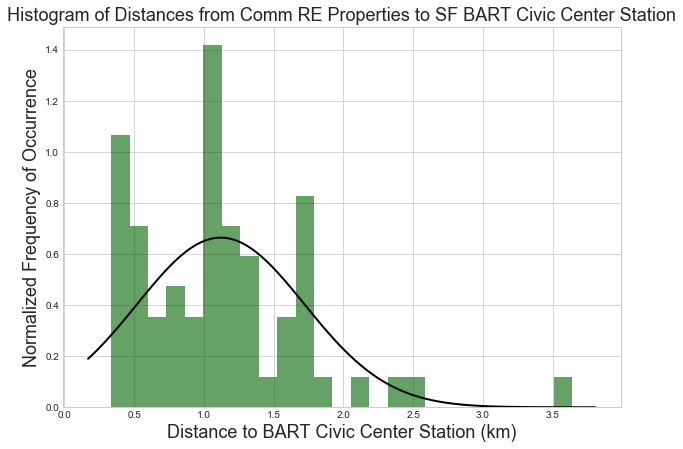

Mean    Distance to BART Civic Center Station =  1.1202430127916116  km
Median  Distance to BART Civic Center Station =  1.0487575650479748  km
Std Dev Distance to BART Civic Center Station =  0.6007978504972227  km


In [65]:
# Calculate distance from each Commercial Real Estate property to BART Rail Civic Center station, 
#  using the geopy function 'distance.geodesic', and plot the resulting histogram

rcParams['figure.figsize'] = 10, 8
import geopy.distance
SFSoMa_DistToBARTCivicStat = np.zeros(len(SF_SoMa_CommRE))
coords_1 = (sfBARTCivicStatLat, sfBARTCivicStatLong)

for i in range(len(SF_SoMa_CommRE)):
    coords_2 = (SFCommRE_LatLongArray[i,0], SFCommRE_LatLongArray[i, 1])
    SFSoMa_DistToBARTCivicStat[i] = geopy.distance.geodesic(coords_1, coords_2).km

# Fit a normal distribution to the data:
rcParams['figure.figsize'] = 10, 7
mu, std = norm.fit(SFSoMa_DistToBARTCivicStat)
# Plot the histogram.
plt.hist(SFSoMa_DistToBARTCivicStat, bins=25, density=True, alpha=0.6, color='darkgreen')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to BART Civic Center Station (km)', fontsize=18)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=18)
plt.title('Histogram of Distances from Comm RE Properties to SF BART Civic Center Station', fontsize=18)
plt.show()

print('Mean    Distance to BART Civic Center Station = ', np.mean(SFSoMa_DistToBARTCivicStat), ' km')
print('Median  Distance to BART Civic Center Station = ', np.median(SFSoMa_DistToBARTCivicStat), ' km')
print('Std Dev Distance to BART Civic Center Station = ', np.std(SFSoMa_DistToBARTCivicStat), ' km')

### 3(a)(2): Evaluate Ease of Public Transportation Access for the Commercial Real Estate Properties in the SEA Pioneer Square Neighborhood. Calculate the mean and median distances from the SEA Commercial Real Estate available properties to the nearest Seattle Sound Transit Link light rail public transportation station.

In [66]:
AddressSeattlePS = 'Seattle, WA / Pioneer Square Area'
#location_SeattlePS = getlocation(AddressSeattlePS)
latitude_SeattlePS = 47.601954
longitude_SeattlePS = -122.329204

In [67]:
# Display first record for the commercial real estate property file: SEA_PS_CommRE (Pandas dataframe)
SEA_PS_CommRE[0:1]

Address     City State Zip Code Neighborhood Property Sq Ft  \
0  675 S Lane Street  Seattle    WA    98104   Pioneer Sq          1,475   

  List Rental Price/Month Price per SqFt/Year Description / Characterization  \
0              $2,950.00              $24.00                          Office   

  Rent Range (if provided) Listing Website  
0                      NaN    cityfeet.com

In [68]:
# SEA Commercial Properties locations
# Display first record for the commercial real estate property file: SEA_PS_CommRE -- build CSV address location for geocoder
geocode_location = (SEA_PS_CommRE.iloc[0, 0] + ',' + SEA_PS_CommRE.iloc[0, 1] + ',' + SEA_PS_CommRE.iloc[0, 2] + ',' + SEA_PS_CommRE.iloc[0, 3])

# GeoCoders-Nominatum: retrieve Lat-Long coordinates for first Comm RE property (from .CSV file)
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("675 S Lane Street, Seattle, WA 98104")
SEACommPropertyLat = location.latitude
SEACommPropertyLong = location.longitude

print('Formatted address geocode_location, for first Seattle Comm RE record value (in CSV format) =\n ', geocode_location)
print('Property Address (CSV format):\n ', location.address)
print('Lat-Long Coordinates:\n ', (SEACommPropertyLat, SEACommPropertyLong))
# print('\nLocation Raw Record Contents:', location.raw,'\n')

Formatted address geocode_location, for first Seattle Comm RE record value (in CSV format) =
  675 S Lane Street,Seattle,WA,98104
Property Address (CSV format):
  675, South Lane Street, West Edge, International District/Chinatown, Seattle, King County, Washington, 98104, USA
Lat-Long Coordinates:
  (47.596514, -122.3242846)


In [69]:
# Below is code I wrote to generate Lat-Long coordinates for the published SEA Comm RE data, and stored this in a .csv file. 
#  Then I use the SEA Comm RE Lat-Long coordinates to generate the distance from each of these properties to the nearest
#  public transportation rail station, specifically to the SEA Light Rail Pioneer Square station.

# Methodology: offline I generated the array of Seattle Commercial Real Estate listed locations' latitude-longitude coordinates
#  from data I compiled and generated from published Comm RE data: 'SEA-PioneerSq-Comm-Real-Estate-Dataset-CSV.csv',
#  and stored into the Pandas dataframe: SEA_PS_CommRE. Then I ran these SEA_PS_CommRE addresses through the geocode_location
#  package to generate the SEACommRE_LatLongArray NumPy array of Lat-Long data pairs, matched by index to each of the 
#  SEA_PS_CommRE SEA Comm RE properties.

# Below I show the code I used to generate this, and then just the end NumPy array result: SEACommRE_LatLongArray
#  (because running all the addresses through geocode_location takes a long time, approx. 1-2 minutes)
'''
SEACommRE_LatLongArray = np.zeros(shape=((len(SEA_PS_CommRE)),2))
for i in range(len(SEA_PS_CommRE)):
    geocode_location = (SEA_PS_CommRE.iloc[i, 0] + ',' + SEA_PS_CommRE.iloc[i, 1] + ',' + SEA_PS_CommRE.iloc[i, 2] + ',' + SEA_PS_CommRE.iloc[i, 3])
    location = geolocator.geocode(geocode_location)
    print('i = ', i, '; LocName = ', SEA_PS_CommRE.iloc[i, 0],';  Location Lat & Long: ', location.latitude, location.longitude)
    SEACommRE_LatLongArray[i] = [location.latitude, location.longitude]

print('\nSEACommRE_LatLongArray: \n', SEACommRE_LatLongArray)
np.savetxt("SEACommRE_LatLongArray.csv", SEACommRE_LatLongArray, delimiter=",")
'''

SEACommRE_LatLongArray = genfromtxt('SEACommRE_LatLongArray.csv', delimiter=',')
print('Printing first 4 rows of SEA Commercial Real Estate Lat-Long Array:\n', SEACommRE_LatLongArray[0:4,:])

Printing first 4 rows of SEA Commercial Real Estate Lat-Long Array:
 [[  47.596514  -122.3242846]
 [  47.5996938 -122.3326903]
 [  47.6040908 -122.3323562]
 [  47.6040908 -122.3323562]]


### Calculate distance from each Commercial Real Estate property to the Seattle Light Rail Pioneer Sq. station.

In [70]:
# GeoCoders-Nominatum: locate SEA Light Rail / Pioneer Square Station, retrieve Lat-Long coordinates for this station
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("3rd Ave & James St, Seattle, WA")
SEALinkRailStationLat = location.latitude
SEALinkRailStationLong = location.longitude

print('Seattle Link Rail / Pioneer Square Station Latitude:', SEALinkRailStationLat)
print('Seattle Link Rail / Pioneer Square Station Latitude:', SEALinkRailStationLong)

Seattle Link Rail / Pioneer Square Station Latitude: 47.6026421
Seattle Link Rail / Pioneer Square Station Latitude: -122.331184


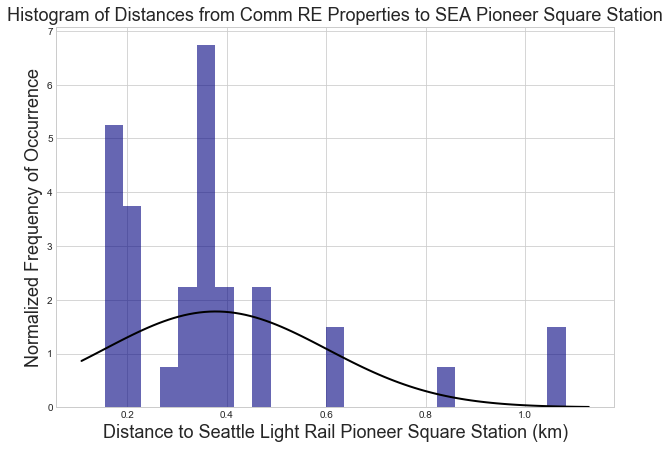

Mean    Distance to Pioneer Square Station =  0.37739335412958364  km
Median  Distance to Pioneer Square Station =  0.345371181277514  km
Std Dev Distance to Pioneer Square Station =  0.22391925869828758  km


In [71]:
# Calculate distance from each Commercial Real Estate property to SEA Pioneer Square station, 
#  using the geopy function 'distance.geodesic', and plot the resulting histogram

rcParams['figure.figsize'] = 10, 8
SEA_PS_DistToLightRailStatPS = np.zeros(len(SEA_PS_CommRE))
coords_1 = (SEALinkRailStationLat, SEALinkRailStationLong)

for i in range(len(SEA_PS_CommRE)):
    coords_2 = (SEACommRE_LatLongArray[i,0], SEACommRE_LatLongArray[i, 1])
    SEA_PS_DistToLightRailStatPS[i] = geopy.distance.geodesic(coords_1, coords_2).km

# Fit a normal distribution to the data:
rcParams['figure.figsize'] = 10, 7
mu, std = norm.fit(SEA_PS_DistToLightRailStatPS)
# Plot the histogram.
plt.hist(SEA_PS_DistToLightRailStatPS, bins=25, density=True, alpha=0.6, color='navy')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Seattle Light Rail Pioneer Square Station (km)', fontsize=18)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=18)
plt.title('Histogram of Distances from Comm RE Properties to SEA Pioneer Square Station', fontsize=18)
plt.show()

print('Mean    Distance to Pioneer Square Station = ', np.mean(SEA_PS_DistToLightRailStatPS), ' km')
print('Median  Distance to Pioneer Square Station = ', np.median(SEA_PS_DistToLightRailStatPS), ' km')
print('Std Dev Distance to Pioneer Square Station = ', np.std(SEA_PS_DistToLightRailStatPS), ' km')

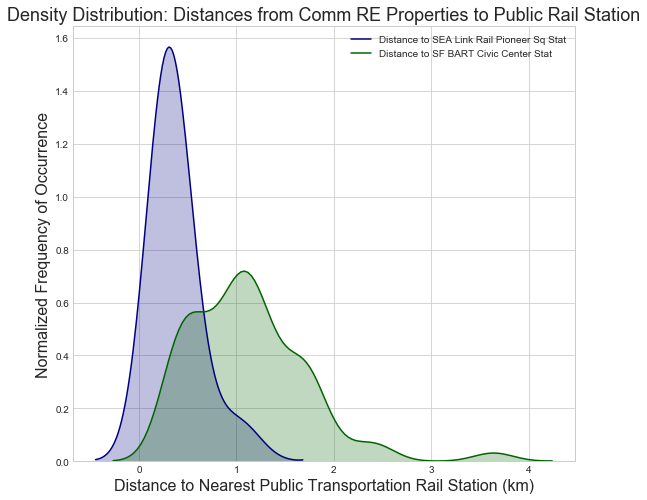

In [72]:
rcParams['figure.figsize'] = 9, 8

sns.kdeplot(SEA_PS_DistToLightRailStatPS, bw=0.2, color='navy', shade=True, label="Distance to SEA Link Rail Pioneer Sq Stat")
sns.kdeplot(SFSoMa_DistToBARTCivicStat, bw=0.2, color = 'darkgreen', shade=True, label="Distance to SF BART Civic Center Stat")

plt.xlabel('Distance to Nearest Public Transportation Rail Station (km)', fontsize=16)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=16)
plt.title('Density Distribution: Distances from Comm RE Properties to Public Rail Station', fontsize=18)
plt.show()

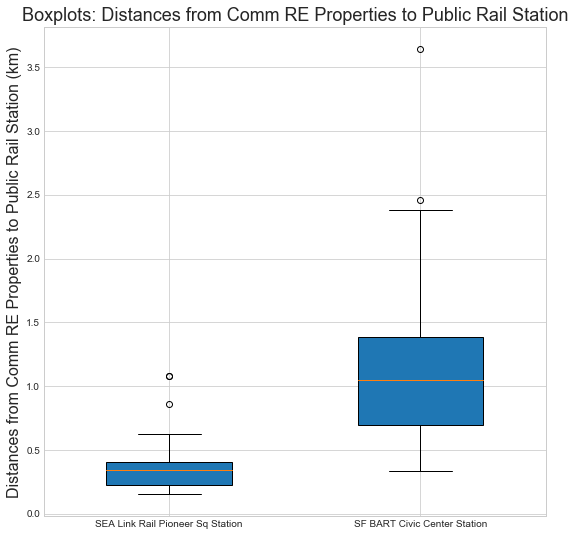

In [73]:
rcParams['figure.figsize'] = 9, 9
fig = plt.figure()
plt.title('Boxplots: Distances from Comm RE Properties to Public Rail Station', fontsize=18)
plt.ylabel('Distances from Comm RE Properties to Public Rail Station (km)', fontsize=16)
box_plot_data = [SEA_PS_DistToLightRailStatPS, SFSoMa_DistToBARTCivicStat]
plt.boxplot(box_plot_data, patch_artist = True, labels = ['SEA Link Rail Pioneer Sq Station', 'SF BART Civic Center Station'], widths=(0.5, 0.5))
plt.show()

### Parts 3(b): Employee Quality of Life: access Foursquare to count the number of Restaurants in each neighborhood.
### 3(b)(1): Restaurants analysis: San Francisco / SoMa neighborhood.

In [74]:
# Search for a Specific Venue Category
# https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT

search_query = 'Restaurant'
radius = 1600
limit = 200

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_SFSoMa, longitude_SFSoMa, VERSION, search_query, radius, limit)
url

'https://api.foursquare.com/v2/venues/search?client_id=0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL&client_secret=OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI&ll=37.77919,-122.398102&v=20180605&query=Restaurant&radius=1600&limit=200'

In [75]:
# Send the GET Request and examine the results
results = requests.get(url).json()
# results

# Assign selected parts of the 'results' JSON object to variable 'venues'
venues = results['response']['venues']
# venues

# Tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head()

dataframe.shape

(50, 25)

In [76]:
# Filter the Pandas dataframe 'dataframe' for only columns that include venue name & info for that specific location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# dataframe_filtered.head()

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered.head()

name          categories         address  \
0  The Chieftain Irish Pub & Restaurant           Irish Pub      198 5th St   
1                 Mars Bar & Restaurant                 Bar  798 Brannan St   
2   Canton Dim Sum & Seafood Restaurant  Chinese Restaurant   655 Folsom St   
3                    B Restaurant & Bar              Lounge   720 Howard St   
4                       Restaurant Anzu          Restaurant    222 Mason St   

   cc           city        country      crossStreet  distance  \
0  US  San Francisco  United States     at Howard St       656   
1  US  San Francisco  United States        at 7th St       795   
2  US  San Francisco  United States  at Hawthorne St       604   
3  US  San Francisco  United States    btw 4th & 5th       684   
4  US  San Francisco  United States      at Ellis St      1240   

                                    formattedAddress  \
0  [198 5th St (at Howard St), San Francisco, CA ...   
1  [798 Brannan St (at 7th St), San Francisco, CA...   
2  [655 Folsom St (at Hawthorne St), San Francisc...   
3  [720 Howard St (btw 4th & 5th), San Francisco,...   
4  [222 Mason St (at Ellis St), San Francisco, CA...   

                                      labeledLatLngs        lat         lng  \
0  [{'label': 'display', 'lat': 37.78150216218952...  37.781502 -122.404972   
1  [{'label': 'display', 'lat': 37.77324531616279...  37.773245 -122.403121   
2  [{'label': 'display', 'lat': 37.78461802766915...  37.784618 -122.397991   
3  [{'label': 'display', 'lat': 37.78465243491517...  37.784652 -122.401668   
4  [{'label': 'display', 'lat': 37.78570272873303...  37.785703 -122.409542   

  neighborhood postalCode state                        id  
0          NaN      94103    CA  42717900f964a5206a211fe3  
1          NaN      94103    CA  3fd66200f964a520adec1ee3  
2          NaN      94107    CA  49ee94a7f964a5206f681fe3  
3          NaN      94103    CA  4b62377ff964a520c53c2ae3  
4          NaN      94102    CA  49efdfa9f964a52015691fe3

In [77]:
dataframe_filtered.shape

(50, 16)

### 3(b)(2): Restaurants analysis: Seattle / Pioneer Square neighborhood.

In [78]:
# Search for a Specific Venue Category
# https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT

search_query = 'Restaurant'
radius = 1600
limit = 200

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_SeattlePS, longitude_SeattlePS, VERSION, search_query, radius, limit)
url

'https://api.foursquare.com/v2/venues/search?client_id=0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL&client_secret=OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI&ll=47.601954,-122.329204&v=20180605&query=Restaurant&radius=1600&limit=200'

In [79]:
# Send the GET Request and examine the results
results = requests.get(url).json()
# results

# Assign selected parts of the 'results' JSON object to variable 'venues'
venues = results['response']['venues']
# venues

# Tranform venues into a Pandas dataframe
dataframe = json_normalize(venues)
# dataframe.head()

dataframe.shape

(50, 24)

In [80]:
# Filter the Pandas dataframe 'dataframe' for only columns that include venue name & info for that specific location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
dataframe_filtered.head()

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered.head()

name          categories            address  \
0            Harbor City Restaurant  Chinese Restaurant      707 S King St   
1               New Star Restaurant  Chinese Restaurant   516 S Jackson St   
2               Lowell's Restaurant  Seafood Restaurant       1519 Pike Pl   
3            Bush Garden Restaurant         Karaoke Bar  614 Maynard Ave S   
4  The Fisherman's Restaurant & Bar  Seafood Restaurant   1301 Alaskan Way   

   cc     city        country   crossStreet  distance  \
0  US  Seattle  United States  at 7th Ave S       591   
1  US  Seattle  United States  at 5th Ave S       341   
2  US  Seattle  United States        at 1st      1197   
3  US  Seattle  United States           NaN       638   
4  US  Seattle  United States    On Pier 57      1087   

                                    formattedAddress  \
0  [707 S King St (at 7th Ave S), Seattle, WA 981...   
1  [516 S Jackson St (at 5th Ave S), Seattle, WA ...   
2  [1519 Pike Pl (at 1st), Seattle, WA 98101, Uni...   
3  [614 Maynard Ave S, Seattle, WA 98104, United ...   
4  [1301 Alaskan Way (On Pier 57), Seattle, WA 98...   

                                      labeledLatLngs        lat         lng  \
0  [{'label': 'display', 'lat': 47.59837711767561...  47.598377 -122.323382   
1  [{'label': 'display', 'lat': 47.59924168108387...  47.599242 -122.327088   
2  [{'label': 'display', 'lat': 47.6089372, 'lng'...  47.608937 -122.341346   
3  [{'label': 'display', 'lat': 47.59699150849453...  47.596992 -122.324930   
4  [{'label': 'display', 'lat': 47.60612306667809...  47.606123 -122.342305   

  postalCode state                        id  
0      98104    WA  4b2d2a7cf964a520facf24e3  
1      98104    WA  4a8c56e7f964a520b60d20e3  
2      98101    WA  454c474af964a520bb3c1fe3  
3      98104    WA  428d2880f964a520b1231fe3  
4      98101    WA  4a988ca3f964a520a92c20e3

In [81]:
dataframe_filtered.shape

(50, 15)

### Part 3(c): Employee Quality of Life: access Foursquare to count the number of Gyms / Fitness Centers in each neighborhood.
### 3(c)(1): Gym / Fitness Centers analysis: San Francisco / SoMa neighborhood.

In [82]:
# Search for a Specific Venue Category
# https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT

search_query = 'Gym'
radius = 1600
limit = 100

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_SFSoMa, longitude_SFSoMa, VERSION, search_query, radius, limit)
url

'https://api.foursquare.com/v2/venues/search?client_id=0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL&client_secret=OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI&ll=37.77919,-122.398102&v=20180605&query=Gym&radius=1600&limit=100'

In [83]:
# Send the GET Request and examine the results
results = requests.get(url).json()
# results

# Assign selected parts of the 'results' JSON object to variable 'venues'
venues = results['response']['venues']
# venues

# Tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head()

dataframe.shape

(50, 19)

In [84]:
# Filter the Pandas dataframe 'dataframe' for only columns that include venue name & info for that specific location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# dataframe_filtered.head()

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered.head()

name            categories  \
0                 Gym Beacon                   Gym   
1  Avalon at Mission Bay Gym                   Gym   
2      Google Gym - SPEAR121  Gym / Fitness Center   
3                  World Gym                   Gym   
4      Embarcadero Tower Gym                   Gym   

                                address  cc           city        country  \
0  250 King Street, 4th Floor Courtyard  US  San Francisco  United States   
1                           383 King St  US  San Francisco  United States   
2                                   NaN  US  San Francisco  United States   
3                    290 De Haro Street  US  San Francisco  United States   
4                            88 King St  US  San Francisco  United States   

  crossStreet  distance                                   formattedAddress  \
0         NaN       398  [250 King Street, 4th Floor Courtyard, San Fra...   
1  at 5th St.       541  [383 King St (at 5th St.), San Francisco, CA 9...   
2         NaN      1515           [San Francisco, CA 94105, United States]   
3  at 16th St      1458  [290 De Haro Street (at 16th St), San Francisc...   
4  2nd Street       808  [88 King St (2nd Street), San Francisco, CA 94...   

                                      labeledLatLngs        lat         lng  \
0  [{'label': 'display', 'lat': 37.77775180480304...  37.777752 -122.393948   
1  [{'label': 'display', 'lat': 37.77593451669104...  37.775935 -122.393527   
2  [{'label': 'display', 'lat': 37.79195025910042...  37.791950 -122.392085   
3  [{'label': 'display', 'lat': 37.76646086077708...  37.766461 -122.402019   
4  [{'label': 'display', 'lat': 37.78046307075421...  37.780463 -122.389059   

       neighborhood postalCode state                        id  
0               NaN      94107    CA  4bc911b4b6c49c74c7d88d91  
1               NaN      94158    CA  4bb0b90df964a5209c573ce3  
2               NaN      94105    CA  5ba04ecb286fda002cea2fe4  
3  Showplace Square      94103    CA  446286f1f964a52018331fe3  
4               NaN      94107    CA  4b4246f6f964a5208dd025e3

In [85]:
dataframe_filtered.shape

(50, 16)

### 3(c)(2): Gym / Fitness Centers analysis: Seattle / Pioneer Square neighborhood.

In [86]:
# Search for a Specific Venue Category
# https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT

search_query = 'Gym'
radius = 1600
limit = 100

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_SeattlePS, longitude_SeattlePS, VERSION, search_query, radius, limit)
url

'https://api.foursquare.com/v2/venues/search?client_id=0L5LJUZ1ZRIICXKIV3JEBXMSIR2A2WUKTL2PYY2UE22TX5DL&client_secret=OE2B2ZNPTMOQCWJATIXF1IBTKWIMPZT5Q3OO0PE2LBPN0UFI&ll=47.601954,-122.329204&v=20180605&query=Gym&radius=1600&limit=100'

In [87]:
# Send the GET Request and examine the results
results = requests.get(url).json()
# results

# Assign selected parts of the 'results' JSON object to variable 'venues'
venues = results['response']['venues']
# venues

# Tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head(8)

dataframe.shape

(50, 18)

In [88]:
# Filter the Pandas dataframe 'dataframe' for only columns that include venue name & info for that specific location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# dataframe_filtered.head()

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered.head()

name            categories            address  cc  \
0           The Post Gym  Gym / Fitness Center    888 Western Ave  US   
1                    Gym  Gym / Fitness Center  1801 S Jackson St  US   
2  Gym at Hilton Seattle  Gym / Fitness Center       1301 6th Ave  US   
3       Crowne Plaza Gym                   Gym       1113 6th Ave  US   
4       Harbor Steps Gym                   Gym       1221 1st Ave  US   

      city        country       crossStreet  distance  \
0  Seattle  United States  Marion & Western       561   
1  Seattle  United States               NaN      1614   
2  Seattle  United States               NaN       910   
3  Seattle  United States               NaN       716   
4  Seattle  United States        University       860   

                                    formattedAddress  \
0  [888 Western Ave (Marion & Western), Seattle, ...   
1  [1801 S Jackson St, Seattle, WA 98144, United ...   
2   [1301 6th Ave, Seattle, WA 98101, United States]   
3   [1113 6th Ave, Seattle, WA 98101, United States]   
4  [1221 1st Ave (University), Seattle, WA 98101,...   

                                      labeledLatLngs        lat         lng  \
0  [{'label': 'display', 'lat': 47.60318992444650...  47.603190 -122.336452   
1  [{'label': 'display', 'lat': 47.599087, 'lng':...  47.599087 -122.308114   
2  [{'label': 'display', 'lat': 47.60887555668738...  47.608876 -122.335657   
3  [{'label': 'display', 'lat': 47.60808284363962...  47.608083 -122.332118   
4  [{'label': 'display', 'lat': 47.60632437897696...  47.606324 -122.338655   

  postalCode state                        id  
0      98104    WA  51f078c7498ea2071245ca51  
1      98144    WA  5ca8f889cb3fd20039e86fa1  
2      98101    WA  4f12faa6e4b0aabf194c2d58  
3      98101    WA  4e4d5dc7483b7f119cc7be7f  
4      98101    WA  4b8ddc32f964a5200c1133e3

In [89]:
dataframe_filtered.shape

(50, 15)

## Results: Business Location Decision Analysis for Two Neighborhoods: SF / SoMa District and Seattle / Pioneer Square

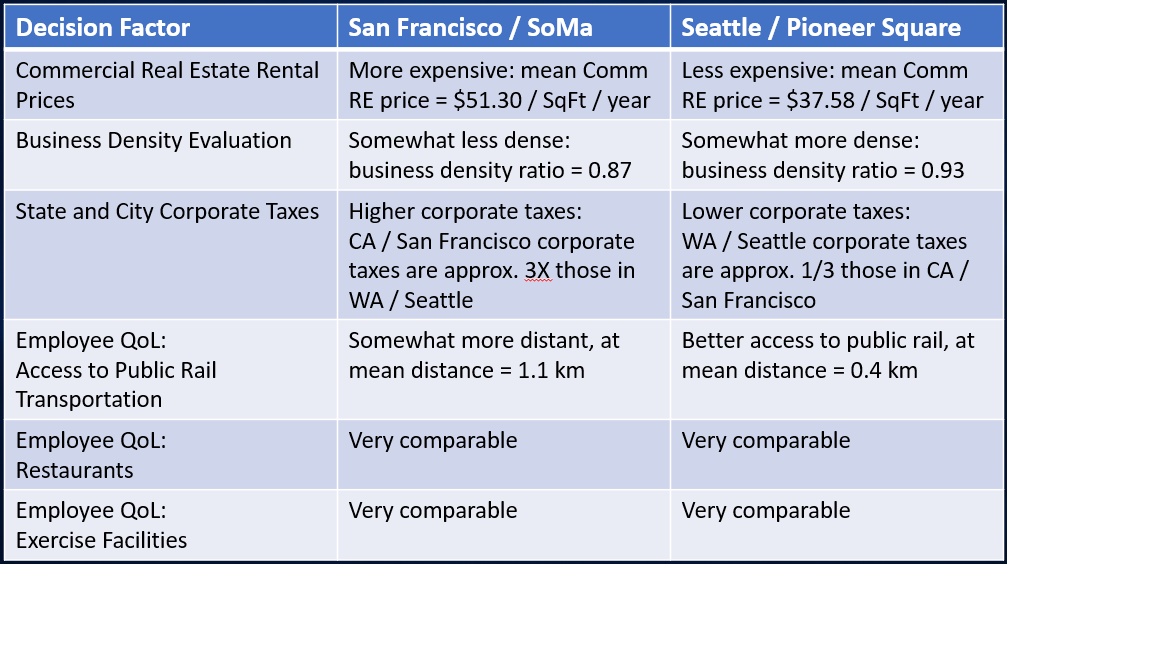

In [90]:
# Sample of tech companies in Seattle Pioneer Square neighborhood
# Image source: Colliers International, referenced at www.geekwire.com
Image(filename="SF-SEA-Results-Table.png", width=900, height=680)

## Discussion of Results
#### With the Results table (above), I constructed a scoring mechanism to judge the business location decision across the six influential factors analyzed, weighting Corporate Financial Impact at 80% and Employee QoL at 20%, and comparing mean scores for each factor:

#### Weighting Judgment Measure:

  = (Corporate Financial Impact factors)\*80% + (Employee Quality of Life factors)\*20%
  
  = (Business Density)\*50% + (Comm RE Prices)\*20% + (Corporate Taxes)\*10% + (Empl. Access to Public Rail)\*8% + (Restaurants)\*6% + (Exercise Facilities)\*6%]

#### SF / SoMa District scoring result:

     = (0.87*50%)+(0.73*20%)+(0.33*10%)+(0.4*8%)+(1.0*6%)+(1.0*6%)
     = 0.77
       
#### Seattle / Pioneer Sq scoring result:

     = (0.93*50%)+(1.0*20%)+(1.0*10%)+(1.0*8%)+(1.0*6%)+(1.0*6%)
     = 0.96

### Based on the above factors considered and the scoring mechanism, Seattle / Pioneer Square scores higher and shows to be a more attractive technology startup business location.

### However, there are clearly additional factors to consider for the location of a technology-based professional services company startup, especially:

- Access to skilled technology personnel to staff the specific business (this may favor San Francisco).
- If the firm is venture capital funded, then the venture capitalists' preferences for location are clearly important.

## Conclusion - Battle of the Neighborhoods: Decision on Where to Locate a Professional Services Business

### Based on the analysis in this data science study on where to locate a professional services company, I would prioritize locating the professional services business in Seattle / Pioneer Square, a location with substantially lower corporate costs than in San Francisco, and with comparable concentration of high tech startup companies and employee quality of life.

### Next steps: a more thorough analysis of locating the business will include:

- Assess access to skilled technology personnel to staff the specific business.
- If the firm is venture capital funded, then the VCs' preferences for location are clearly important.
- Assess one's professional network and contacts in the region to start the business.

### Key Functions and Skills Developed in this IBM Data Science Capstone Project:
This project significantly strengthened my skills in several aspects of Data Science project planning and programming. Planning the study content for the target audience and the targeted decisions is critical, as is careful mapping of the science/mathematics methodology to programming language functions and libraries. Furthering my skills in Python Pandas and Scikit-Learn has been valuable for structuring datasets and to design machine learning optimizations. Enhancing my skills with Folium enables delivering powerful geographical visualizations.

### I definitely believe this IBM Data Science Professional Certification Program is high quality. The curriculum design and completing the projects builds expertise to design serious data science and data visualization projects. Thank you to the team.